<a href="https://www.kaggle.com/code/siddp6/landscape-generative-adversarial-networks?scriptVersionId=177093993" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Imports

In [1]:
import torch
import os

import torchvision.transforms as T
import matplotlib.pyplot as plt  
import torch.nn as nn

from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import torch.nn.functional as F

## Data

In [2]:
data_path = "/kaggle/input/landscape-pictures"

In [3]:
image_size = 256
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) 
batch_size = 128

transformer = T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(.5),
    T.ToTensor(),
    T.Normalize(*stats)
])

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = [os.path.join(root_dir, img) for img in os.listdir(root_dir) if img.endswith(('png', 'jpg', 'jpeg'))]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

dataset = CustomImageDataset(data_path, transform=transformer)


In [5]:
dataset_loader = DataLoader(dataset, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=2):
    plt.imshow(make_grid(denorm(images[:nmax]), nrow=2).permute(1, 2, 0))

def show_batch(dl):
    for images in dl:
        show_images(images)
        break

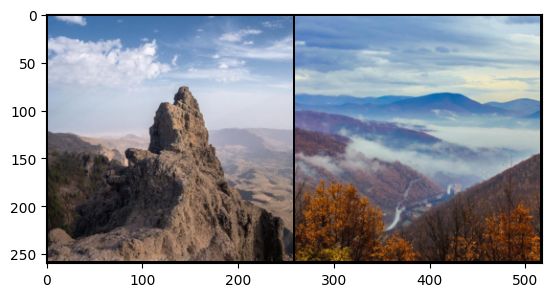

In [7]:
show_batch(dataset_loader)

## Discriminator and Generator

In [8]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Input: 256x256, Output: 128x128
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 64x64
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 32x32
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 16x16
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 8x8
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 4x4
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),  # Output: 1x1

    nn.Flatten(),
    nn.Sigmoid()
)

In [9]:
latent_size = 512

generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 1024, kernel_size=4, stride=1, padding=0, bias=False),  # Output: 4x4
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 1024, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 8x8
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 16x16
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 32x32
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 64x64
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 128x128
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),  # Output: 256x256
    nn.BatchNorm2d(32),
    nn.ReLU(True),

    nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1, bias=False),
    nn.Tanh()  # Normalize output to [-1, 1]
)

## Set GPU

In [10]:
def get_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    else:
        return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for data in self.dl:
            yield to_device(data, self.device)
    
    def __len__(self):
        return len(self.dl)

In [11]:
device = get_device()

dataset_loader = DeviceDataLoader(dataset_loader, device)
print(f"Train loader device: {next(iter(dataset_loader))[0].device}")

discriminator = to_device(discriminator, device)
print(f"Discriminator device: {next(discriminator.parameters()).device}")

generator = to_device(generator, device)
print(f"Generator device: {next(generator.parameters()).device}")

Train loader device: cuda:0
Discriminator device: cuda:0
Generator device: cuda:0


## Training

torch.Size([128, 512, 1, 1])
torch.Size([128, 3, 256, 256])


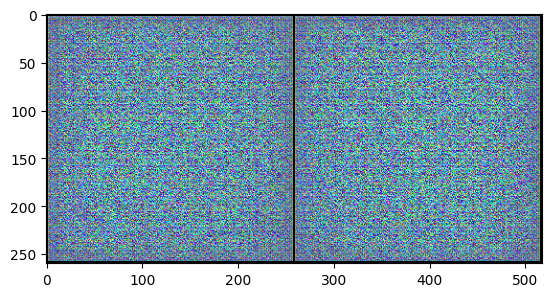

In [12]:
xb = torch.randn(batch_size, 512, 1, 1) # random latent tensors
xb = to_device(xb, device)
fake_images = generator(xb)
print(xb.shape)
print(fake_images.shape)
fake_images_cpu = fake_images.cpu()  # Move the tensor to CPU
show_images(fake_images_cpu)

In [13]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [14]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [15]:
fixed_latent = torch.randn(128, latent_size, 1, 1, device=device)

In [16]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [17]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images in tqdm(dataset_loader):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        if epoch % 10 == 0 or epoch == epochs - 1: save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 3.0399, loss_d: 0.9036, real_score: 0.7398, fake_score: 0.3775


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 5.6014, loss_d: 0.0722, real_score: 0.9809, fake_score: 0.0502


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 2.4049, loss_d: 0.5649, real_score: 0.7909, fake_score: 0.1265


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 7.0700, loss_d: 0.6436, real_score: 0.8507, fake_score: 0.2950


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 1.4288, loss_d: 1.2522, real_score: 0.6263, fake_score: 0.4099


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 1.1014, loss_d: 1.2051, real_score: 0.5180, fake_score: 0.3082


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 2.2135, loss_d: 1.1980, real_score: 0.6787, fake_score: 0.5304


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 1.8514, loss_d: 1.7044, real_score: 0.4696, fake_score: 0.5623


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 2.7436, loss_d: 0.5130, real_score: 0.7774, fake_score: 0.2095


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 0.5701, loss_d: 0.7966, real_score: 0.6804, fake_score: 0.2840


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 2.3524, loss_d: 1.7109, real_score: 0.8238, fake_score: 0.7484


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 0.7473, loss_d: 1.4118, real_score: 0.4402, fake_score: 0.4050


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 1.1036, loss_d: 1.0639, real_score: 0.5085, fake_score: 0.2940


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 0.9528, loss_d: 1.4570, real_score: 0.6721, fake_score: 0.5779


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 1.4600, loss_d: 1.1280, real_score: 0.5135, fake_score: 0.2779


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 1.5510, loss_d: 0.8345, real_score: 0.5805, fake_score: 0.2051


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 1.3413, loss_d: 1.4283, real_score: 0.3420, fake_score: 0.1181


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 0.9379, loss_d: 0.9015, real_score: 0.7751, fake_score: 0.4347


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 1.5238, loss_d: 0.9946, real_score: 0.7008, fake_score: 0.4382


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 1.6162, loss_d: 1.1507, real_score: 0.4928, fake_score: 0.2130


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 0.9871, loss_d: 1.3742, real_score: 0.4153, fake_score: 0.2984


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.5738, loss_d: 2.3175, real_score: 0.9351, fake_score: 0.8764


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 2.9817, loss_d: 1.7184, real_score: 0.8255, fake_score: 0.7559


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.2273, loss_d: 1.6401, real_score: 0.9191, fake_score: 0.7205


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 1.1520, loss_d: 1.1631, real_score: 0.6048, fake_score: 0.4465


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 1.2199, loss_d: 1.3157, real_score: 0.5920, fake_score: 0.5131


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 2.9359, loss_d: 1.3770, real_score: 0.7030, fake_score: 0.6005


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 2.2751, loss_d: 0.8615, real_score: 0.8395, fake_score: 0.4416


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 2.5035, loss_d: 0.6006, real_score: 0.8815, fake_score: 0.3581


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 1.0827, loss_d: 1.2010, real_score: 0.4548, fake_score: 0.2494


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 1.7906, loss_d: 1.1760, real_score: 0.7936, fake_score: 0.5708


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 2.7183, loss_d: 0.6176, real_score: 0.7320, fake_score: 0.2245


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 1.6294, loss_d: 1.1720, real_score: 0.5091, fake_score: 0.3287


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 1.9924, loss_d: 0.6197, real_score: 0.8232, fake_score: 0.3022


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 0.7567, loss_d: 1.5407, real_score: 0.2819, fake_score: 0.0924


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 3.6681, loss_d: 1.9791, real_score: 0.9678, fake_score: 0.8170


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 2.1030, loss_d: 0.9448, real_score: 0.5290, fake_score: 0.1565


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 1.9507, loss_d: 1.1087, real_score: 0.8820, fake_score: 0.5937


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 2.2143, loss_d: 1.0296, real_score: 0.6165, fake_score: 0.3252


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 1.0751, loss_d: 1.3352, real_score: 0.4100, fake_score: 0.3016


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.4534, loss_d: 0.6676, real_score: 0.8054, fake_score: 0.3390


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 0.9809, loss_d: 1.6845, real_score: 0.2366, fake_score: 0.0338


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 3.8473, loss_d: 1.5833, real_score: 0.8948, fake_score: 0.7142


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 1.8709, loss_d: 1.0876, real_score: 0.6139, fake_score: 0.4036


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 2.2452, loss_d: 1.0766, real_score: 0.7302, fake_score: 0.5003


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 1.9309, loss_d: 0.9634, real_score: 0.5141, fake_score: 0.2077


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 1.0257, loss_d: 1.1351, real_score: 0.4242, fake_score: 0.1601


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 2.3121, loss_d: 1.0153, real_score: 0.8136, fake_score: 0.5279


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 3.1168, loss_d: 0.6182, real_score: 0.7833, fake_score: 0.2786


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 3.2786, loss_d: 1.1574, real_score: 0.7602, fake_score: 0.5593


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 1.7324, loss_d: 1.1809, real_score: 0.6056, fake_score: 0.4148


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 1.4478, loss_d: 1.4491, real_score: 0.3015, fake_score: 0.1076


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 1.6668, loss_d: 2.0566, real_score: 0.1899, fake_score: 0.0576


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 2.0860, loss_d: 1.9980, real_score: 0.1696, fake_score: 0.0102


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 2.5003, loss_d: 1.1747, real_score: 0.7841, fake_score: 0.5814


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 1.3005, loss_d: 1.2230, real_score: 0.3713, fake_score: 0.0518


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 2.6232, loss_d: 1.3892, real_score: 0.7841, fake_score: 0.6279


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 0.6073, loss_d: 1.2452, real_score: 0.3806, fake_score: 0.1413


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 2.5992, loss_d: 0.9670, real_score: 0.7966, fake_score: 0.4686


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 2.5819, loss_d: 0.7917, real_score: 0.7116, fake_score: 0.3329


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 2.1618, loss_d: 0.8017, real_score: 0.6873, fake_score: 0.3165


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 1.7655, loss_d: 0.9597, real_score: 0.4905, fake_score: 0.1672


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.6772, loss_d: 1.4638, real_score: 0.8938, fake_score: 0.6932


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 2.5735, loss_d: 0.7074, real_score: 0.6241, fake_score: 0.1456


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 1.9315, loss_d: 1.1438, real_score: 0.3767, fake_score: 0.0268


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 3.4408, loss_d: 2.1219, real_score: 0.9143, fake_score: 0.8436


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 2.3875, loss_d: 0.6614, real_score: 0.6657, fake_score: 0.1820


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 5.0827, loss_d: 0.8213, real_score: 0.9314, fake_score: 0.4898


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 3.5125, loss_d: 0.8314, real_score: 0.7924, fake_score: 0.4237


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 5.5468, loss_d: 1.0919, real_score: 0.8373, fake_score: 0.5538


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 2.8180, loss_d: 0.7997, real_score: 0.7712, fake_score: 0.3679


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 2.6999, loss_d: 0.6677, real_score: 0.6070, fake_score: 0.0832


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 7.1643, loss_d: 1.2724, real_score: 0.9585, fake_score: 0.6612


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 8.8833, loss_d: 0.9213, real_score: 0.8062, fake_score: 0.4559


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 7.2416, loss_d: 0.7640, real_score: 0.9307, fake_score: 0.4404


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 2.6775, loss_d: 0.3500, real_score: 0.7947, fake_score: 0.0990


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.4756, loss_d: 1.1457, real_score: 0.6879, fake_score: 0.4547


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 2.1685, loss_d: 0.8580, real_score: 0.6145, fake_score: 0.2459


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 9.4770, loss_d: 2.2736, real_score: 0.9615, fake_score: 0.8747


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 1.2930, loss_d: 1.5796, real_score: 0.2540, fake_score: 0.0101


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 4.3844, loss_d: 0.5632, real_score: 0.8730, fake_score: 0.3234


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 9.2279, loss_d: 1.2852, real_score: 0.9118, fake_score: 0.6432


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 4.4501, loss_d: 0.1734, real_score: 0.9105, fake_score: 0.0707


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.2258, loss_d: 0.4806, real_score: 0.7713, fake_score: 0.1712


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 3.4129, loss_d: 0.6444, real_score: 0.8414, fake_score: 0.3261


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.3251, loss_d: 1.0483, real_score: 0.8093, fake_score: 0.5138


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 2.5457, loss_d: 0.7480, real_score: 0.6700, fake_score: 0.2528


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 3.2361, loss_d: 0.4766, real_score: 0.7012, fake_score: 0.0413


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 4.0326, loss_d: 0.5315, real_score: 0.7982, fake_score: 0.2116


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 5.2482, loss_d: 0.5491, real_score: 0.9462, fake_score: 0.3507


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 2.9734, loss_d: 0.5073, real_score: 0.7318, fake_score: 0.1330


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 2.7344, loss_d: 0.9885, real_score: 0.6315, fake_score: 0.3470


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 6.2319, loss_d: 0.2799, real_score: 0.7868, fake_score: 0.0128


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 4.2829, loss_d: 1.0852, real_score: 0.8771, fake_score: 0.5486


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 5.0239, loss_d: 0.6004, real_score: 0.9163, fake_score: 0.3725


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 6.2780, loss_d: 0.3648, real_score: 0.9745, fake_score: 0.2550


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 3.4882, loss_d: 0.3889, real_score: 0.7842, fake_score: 0.0990


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 0.8499, loss_d: 1.0606, real_score: 0.4481, fake_score: 0.0720


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 1.8894, loss_d: 2.0655, real_score: 0.1789, fake_score: 0.0021


  0%|          | 0/34 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 2.8030, loss_d: 0.9229, real_score: 0.5400, fake_score: 0.1431


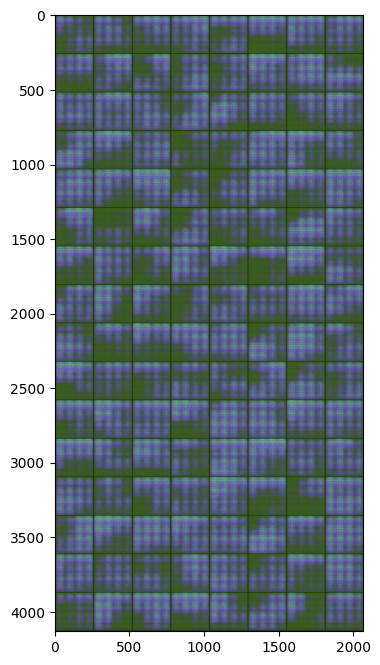

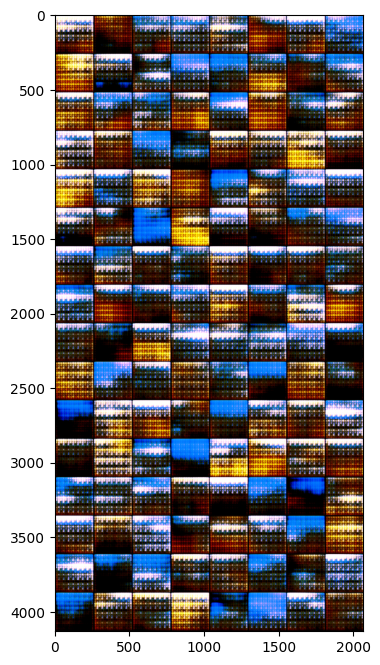

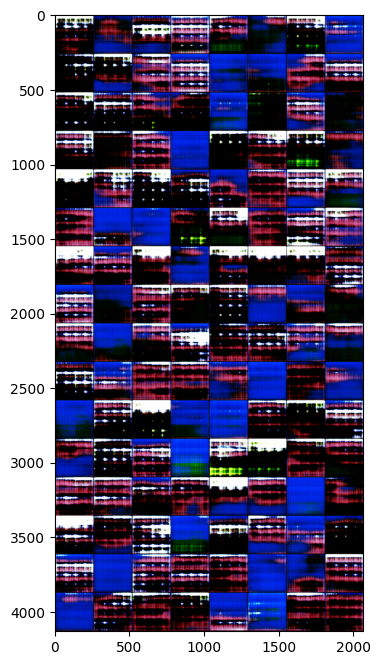

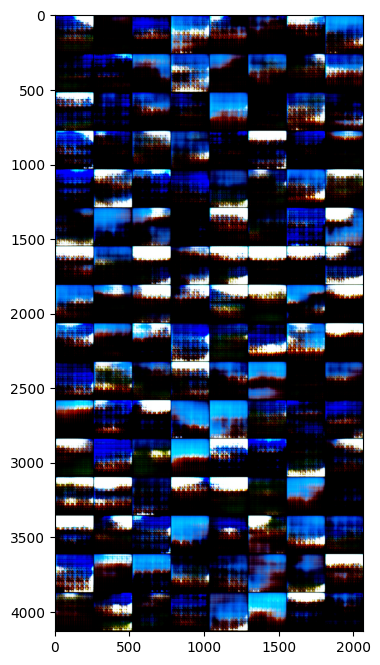

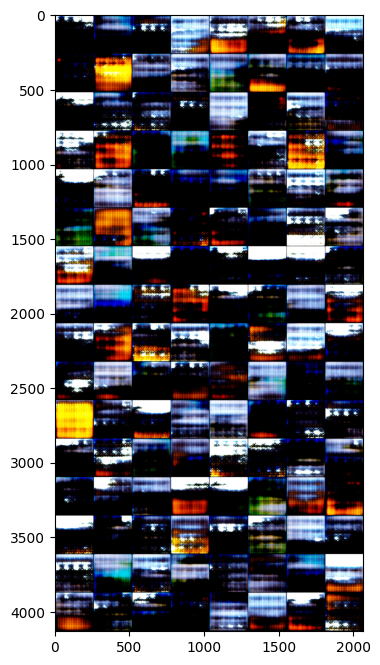

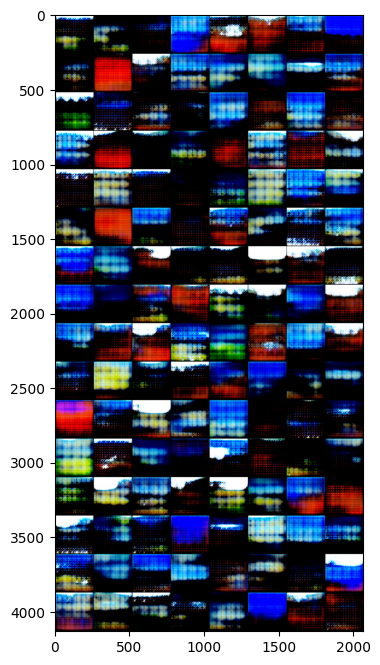

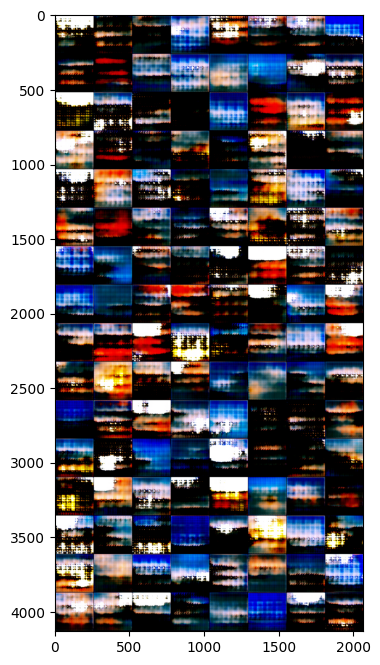

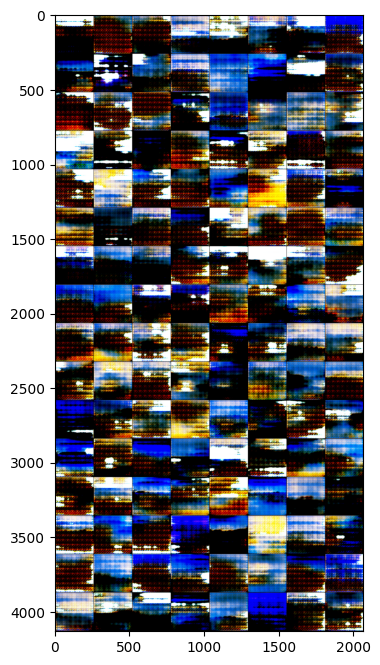

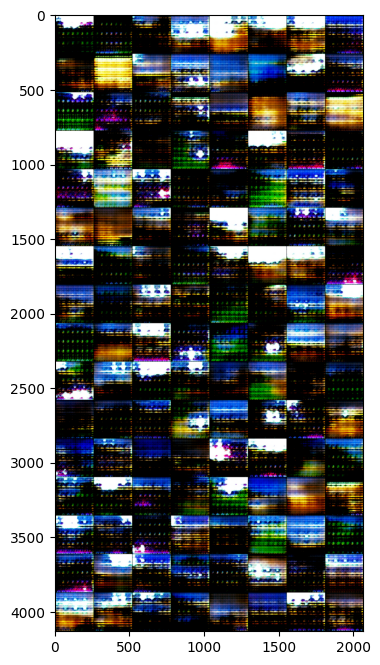

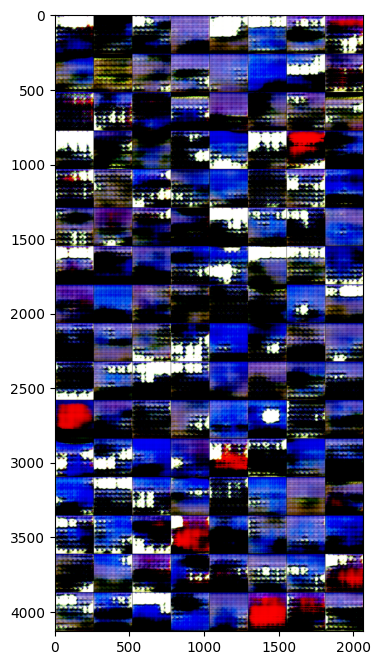

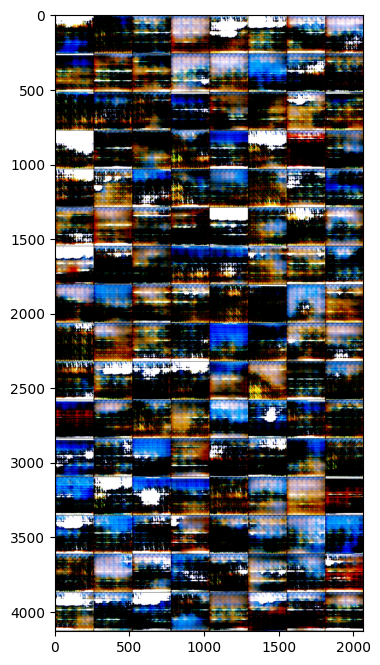

In [18]:
lr = 0.001
epochs = 100
history = fit(epochs, lr)